# Object Detection Module 

In [1]:
label_map = {
    1: "top", 
    2: "bottom", 
    3: "dress"
}

In [2]:
from detector import DetectorTF2 

detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    labelmap= label_map,
    threshold=0.50
)

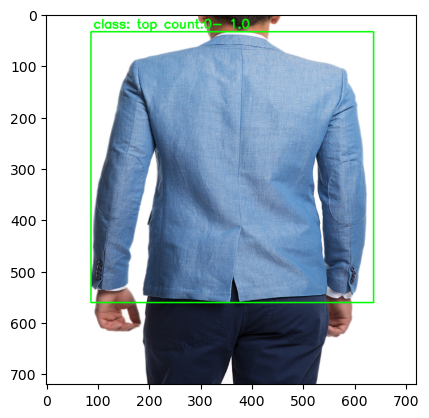

In [3]:
import matplotlib.pyplot as plt 
import cv2 

img = cv2.imread("../data/IMG_all/train/CEKET/6.png")

det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGBA))
plt.show() 

In [4]:
detected_img.shape 

(720, 720, 3)

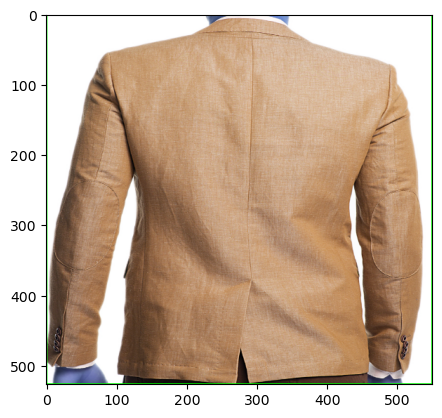

In [5]:
cropped_img = detected_img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] 
plt.imshow(cropped_img)
plt.show() 

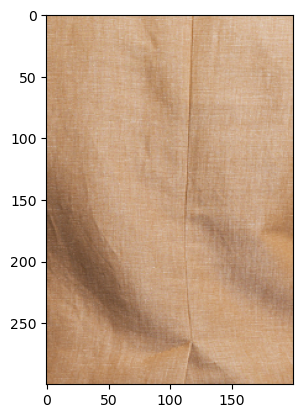

In [6]:
cw = 200 
ch = 300
center = cropped_img.shape
x = center[1]/2 - cw/2
y = center[0]/2 - ch/2
center_cropped = cropped_img[int(y):int(y+ch), int(x):int(x+cw)] 
plt.imshow(center_cropped) 
plt.show() 

# Color-Thief 

In [7]:
from colorthief import ColorThief 

def crop_image(img_path:str, detector: DetectorTF2, sample_wh = (200, 200)): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    
    cw = sample_wh[0] 
    ch = sample_wh[1] 
    center = img.shape
    x = center[1]/2 - cw/2
    y = center[0]/2 - ch/2
    img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

In [20]:
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
               : ]
    
    return img

In [9]:
import io 

def get_dominant_from_image(img_path:str, detector: DetectorTF2,zoom_rate ,sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    byteImgIO = io.BytesIO()
    byteImg = Image.fromarray(img)
    byteImg.save(byteImgIO, "PNG")
    byteImgIO.seek(0)
    byteImg = byteImgIO.read() 
    dataBytesIO = io.BytesIO(byteImg)
    ct = ColorThief(dataBytesIO) 
    
    dominant_color = ct.get_color(quality=1) 
    palette = ct.get_palette(color_count=n_palette, quality=1)  

    return img, detected_img, dominant_color, palette

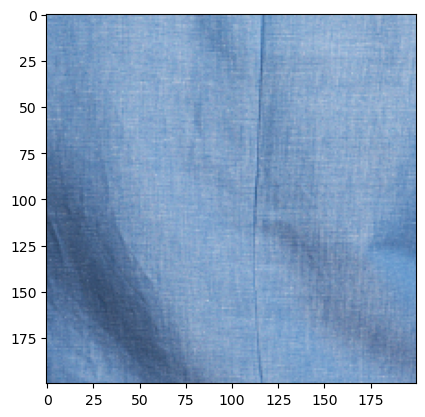

In [10]:
plt.imshow(crop_image("../data/IMG_all/train/CEKET/6.png", detector)) 
plt.show() 

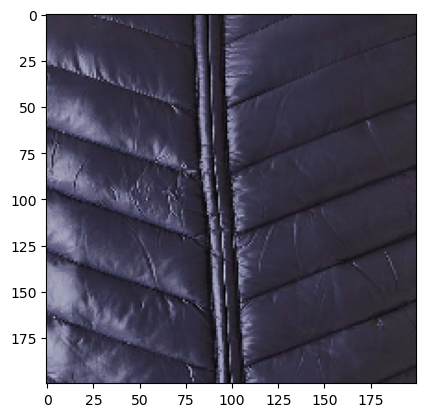

In [11]:
plt.imshow(crop_image("../data/IMG_all/train/dis-giyim/9.png", detector, sample_wh=(200, 200))) 
plt.show() 

# Clustering Method 

In [7]:
import cv2
import numpy as np

img = cv2.imread('../data/IMG_all/demo/manolya_kadin.png')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

number_clusters = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

compactness, centers

(1121829781.4031746,
 array([[233.14333, 233.93411, 246.58176],
        [105.26284, 137.79655, 189.83284]], dtype=float32))

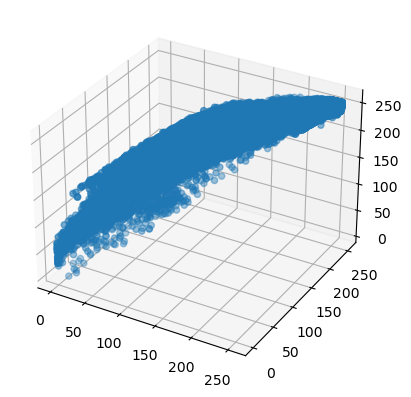

In [8]:
import pandas as pd 

dt = pd.DataFrame(data)
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
ax.scatter(dt.iloc[:, 0], dt.iloc[:, 1], dt.iloc[:, 2])

### K-Means Elbow 

In [9]:
from sklearn.cluster import KMeans

img = cv2.imread('../data/IMG_all/demo/manolya_kadin.png')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

costs = [] 
K = np.array(range(1,10))
for k in K:    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, k, None, criteria, 10, flags) 
    costs.append(compactness)


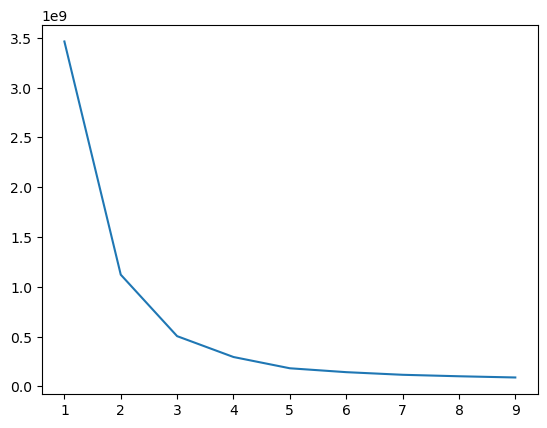

In [10]:
plt.plot(K, costs)
plt.show() 

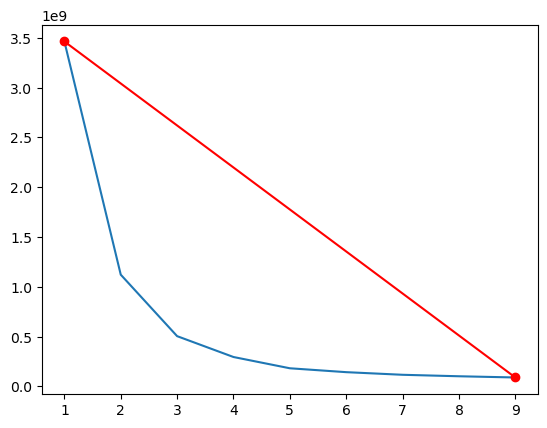

In [11]:
plt.plot(K, costs)
costs = np.array(costs)
plt.plot([K[0], K[-1]], [costs[0], costs[-1]], 'ro-')
plt.show() 

In [12]:
import math
def distance_from_line(x1, y1, a, b, c): 
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d 

In [13]:
a = costs[0] - costs[-1] 
b = K[-1] - K[0] 
c1 = K[0] * costs[-1] 
c2 = K[-1] * costs[0] 
c = c1 - c2   
# line denklemö

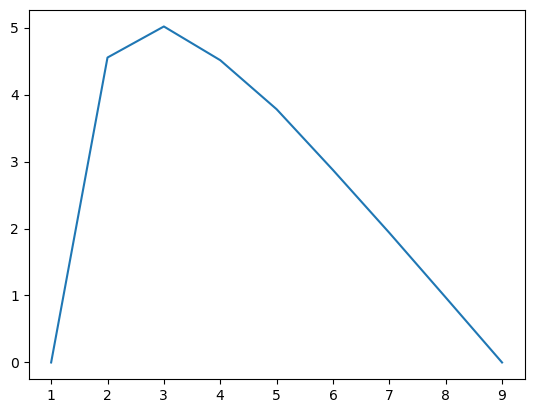

In [14]:
distances_fron_line = [] 
for k in range(len(K)): 
    distances_fron_line.append(distance_from_line(K[k], costs[k], a, b, c)) 

plt.plot(K, distances_fron_line) 

In [15]:
K[distances_fron_line.index(max(distances_fron_line))]

3

In [16]:
def get_dominant_from_image(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, n_palette, None, criteria, 10, flags)
    
    return img, detected_img, centers.astype(np.int16) 

In [17]:
def get_dominant_from_image_autoK(img_path:str, detector: DetectorTF2, zoom_rate, K = range(1,6)): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detected_img = img
    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    
    costs = [] 
    centerss = [] 
    K = np.array(range(1,6))
    for k in K:    
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        flags = cv2.KMEANS_RANDOM_CENTERS
        compactness, labels, centers = cv2.kmeans(data, k, None, criteria, 10, flags) 
        costs.append(compactness)
        centerss.append(centers)
    
    costs = np.array(costs)
    a = costs[0] - costs[-1] 
    b = K[-1] - K[0] 
    c1 = K[0] * costs[-1] 
    c2 = K[-1] * costs[0] 
    c = c1 - c2 

    distances_from_line = [] 
    for k in range(len(K)): 
        distances_from_line.append(distance_from_line(K[k], costs[k], a, b, c)) 
    
    r = distances_fron_line.index(max(distances_fron_line))
    print(K[distances_fron_line.index(max(distances_fron_line))])
    
    return img, detected_img, centerss[r].astype(np.int16) 

In [21]:
img, detected_img, centers  = get_dominant_from_image("../data/IMG_all/demo/kiz_cocuk.png", detector, 2)

3


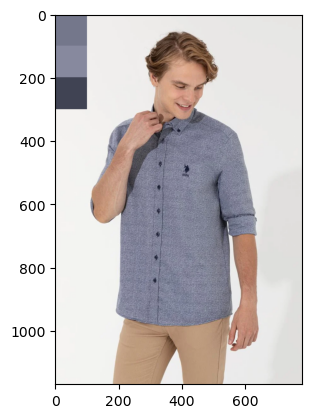

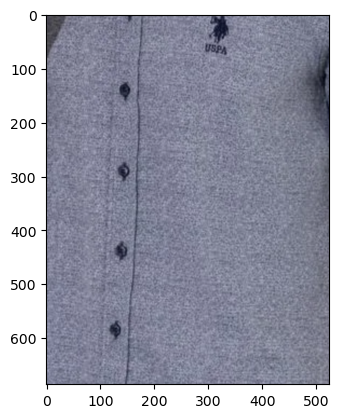

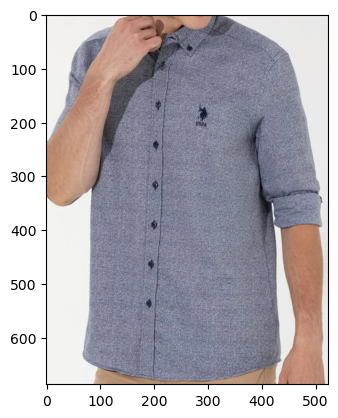

In [38]:
path = "../data/IMG_all/demo/lacivert_erkek_uzun.png"
img, detected_img, centers = get_dominant_from_image_autoK(path, detector=detector, zoom_rate=2, K=range(1, 4))
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = -100
for c in centers: 
    y_point += 100 
    cv = cv2.rectangle(image, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 


plt.imshow(cv)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 

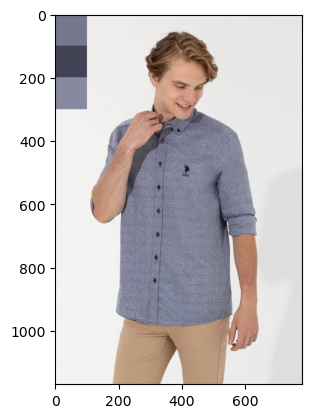

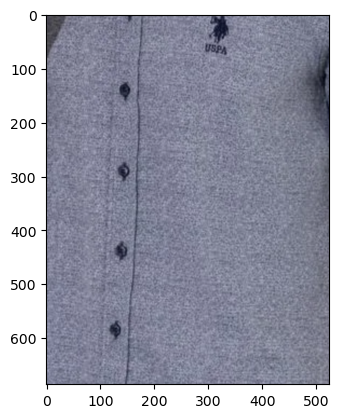

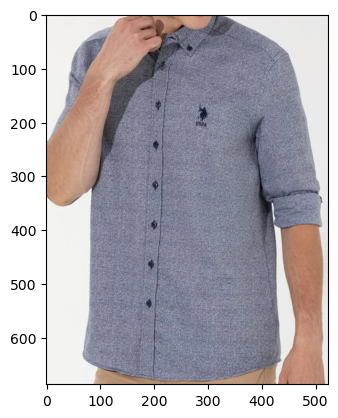

In [57]:
path = "../data/IMG_all/demo/lacivert_erkek_uzun.png"
img, detected_img, centers = get_dominant_from_image(path, detector=detector, zoom_rate=2)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = -100
for c in centers: 
    y_point += 100 
    cv = cv2.rectangle(image, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 


plt.imshow(cv)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 

# K-Modes Clustering 

In [ ]:
# !pip install kmodes

In [54]:
from kmodes.kmodes import KModes 
def get_dominant_from_image_kModes(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    model = KModes(n_clusters=n_palette, init="random", n_init=1, verbose=1) 
    model.fit_predict(data) 

    return img, detected_img, model.cluster_centroids_.astype(np.int16) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1859, cost: 1215285.0


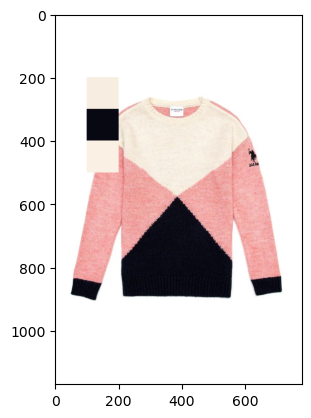

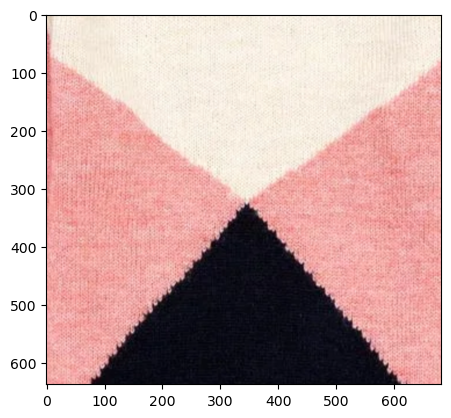

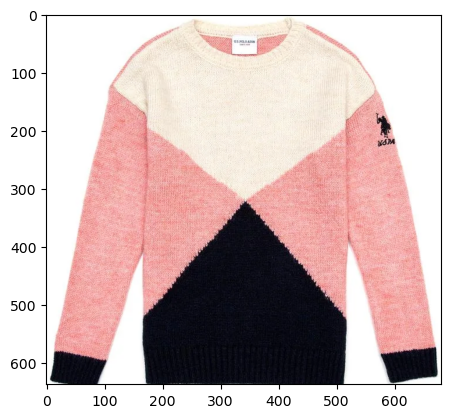

In [59]:
path = "../data/IMG_all/demo/kiz_cocuk.png"
img, detected_img, centers = get_dominant_from_image_kModes(path, detector=detector, zoom_rate=2, sample_wh=(100, 200), n_palette=3)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = 100
for c in centers: 
    y_point += 100 
    cv = cv2.rectangle(image, (100, y_point), (200, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

plt.imshow(cv)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 

# Image Segmentation 

(0.0, 256.0)

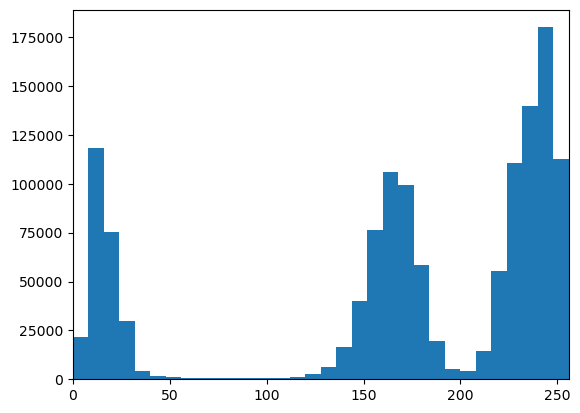

In [61]:
fig, ax = plt.subplots(1, 1)
ax.hist(img.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [63]:
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [73]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

## Active contour segmentation